In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import os

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
os.makedirs('../results', exist_ok=True)


In [3]:
# Carregar dados
df_flights = pd.read_csv('../data/flights_clean.csv')
df = df_flights[df_flights['CANCELLED'] == 0].copy()
df = df.dropna(subset=['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'DISTANCE', 'AIR_TIME'])

# Filtrar aeroportos com volume mínimo
min_flights = 100
airport_counts = df['ORIGIN_AIRPORT'].value_counts()
airports_with_min_volume = airport_counts[airport_counts >= min_flights].index
df_filtered = df[df['ORIGIN_AIRPORT'].isin(airports_with_min_volume)].copy()

# Agregar métricas por aeroporto
df_airports = df_filtered.groupby('ORIGIN_AIRPORT').agg({
    'DEPARTURE_DELAY': ['mean', 'median', 'std', 'count'],
    'ARRIVAL_DELAY': ['mean', 'median', 'std'],
    'AIR_TIME': ['mean', 'median', 'std'],
    'ELAPSED_TIME': ['mean', 'median', 'std'],
    'TAXI_OUT': ['mean', 'median'],
    'TAXI_IN': ['mean', 'median'],
    'DISTANCE': ['mean', 'min', 'max'],
    'CANCELLED': 'sum',
    'DIVERTED': 'sum'
}).reset_index()

df_airports.columns = ['AIRPORT'] + ['_'.join(col).strip() if col[1] else col[0] 
                                  for col in df_airports.columns[1:]]
df_airports['CANCELLATION_RATE'] = df_airports['CANCELLED_sum'] / df_airports['DEPARTURE_DELAY_count']
df_airports['DIVERTED_RATE'] = df_airports['DIVERTED_sum'] / df_airports['DEPARTURE_DELAY_count']


In [4]:
# Selecionar features e preparar dados
features_clustering = [
    'DEPARTURE_DELAY_mean', 'DEPARTURE_DELAY_median', 'DEPARTURE_DELAY_std',
    'ARRIVAL_DELAY_mean', 'ARRIVAL_DELAY_median', 'ARRIVAL_DELAY_std',
    'AIR_TIME_mean', 'AIR_TIME_median', 'AIR_TIME_std',
    'ELAPSED_TIME_mean', 'ELAPSED_TIME_median', 'ELAPSED_TIME_std',
    'TAXI_OUT_mean', 'TAXI_IN_mean',
    'DISTANCE_mean', 'DISTANCE_min', 'DISTANCE_max',
    'DEPARTURE_DELAY_count', 'CANCELLATION_RATE', 'DIVERTED_RATE'
]
features_clustering = [f for f in features_clustering if f in df_airports.columns]

X_cluster = df_airports[features_clustering].copy().dropna()
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)


In [5]:
# Clusterização K=4
kmeans_k4 = KMeans(n_clusters=4, random_state=42, n_init=10, max_iter=300)
labels_k4 = kmeans_k4.fit_predict(X_cluster_scaled)

df_airports_clustered = df_airports[df_airports.index.isin(X_cluster.index)].copy()
df_airports_clustered['CLUSTER'] = labels_k4

silhouette_k4 = silhouette_score(X_cluster_scaled, labels_k4)
print(f"Silhouette Score: {silhouette_k4:.4f}")
print("\nDistribuição de aeroportos por cluster:")
cluster_counts = pd.Series(labels_k4).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    pct = count / len(labels_k4) * 100
    print(f"  Cluster {cluster_id}: {count:,} aeroportos ({pct:.1f}%)")

print("\nCaracterísticas médias por cluster:")
cluster_summary = df_airports_clustered.groupby('CLUSTER').agg({
    'DEPARTURE_DELAY_mean': 'mean',
    'ARRIVAL_DELAY_mean': 'mean',
    'AIR_TIME_mean': 'mean',
    'DISTANCE_mean': 'mean',
    'DEPARTURE_DELAY_count': 'mean',
    'CANCELLATION_RATE': 'mean'
}).round(2)
print(cluster_summary)


Silhouette Score: 0.1697

Distribuição de aeroportos por cluster:
  Cluster 0: 2 aeroportos (0.3%)
  Cluster 1: 207 aeroportos (35.3%)
  Cluster 2: 195 aeroportos (33.2%)
  Cluster 3: 183 aeroportos (31.2%)

Características médias por cluster:
         DEPARTURE_DELAY_mean  ARRIVAL_DELAY_mean  AIR_TIME_mean  \
CLUSTER                                                            
0                       15.79               13.07         354.46   
1                        2.46               -0.41          58.19   
2                        9.37                6.71          74.16   
3                        6.11                0.88         123.01   

         DISTANCE_mean  DEPARTURE_DELAY_count  CANCELLATION_RATE  
CLUSTER                                                           
0              3200.00                 219.00               0.00  
1               352.54                1009.17               0.00  
2               472.63                3314.42               0.00  
3           

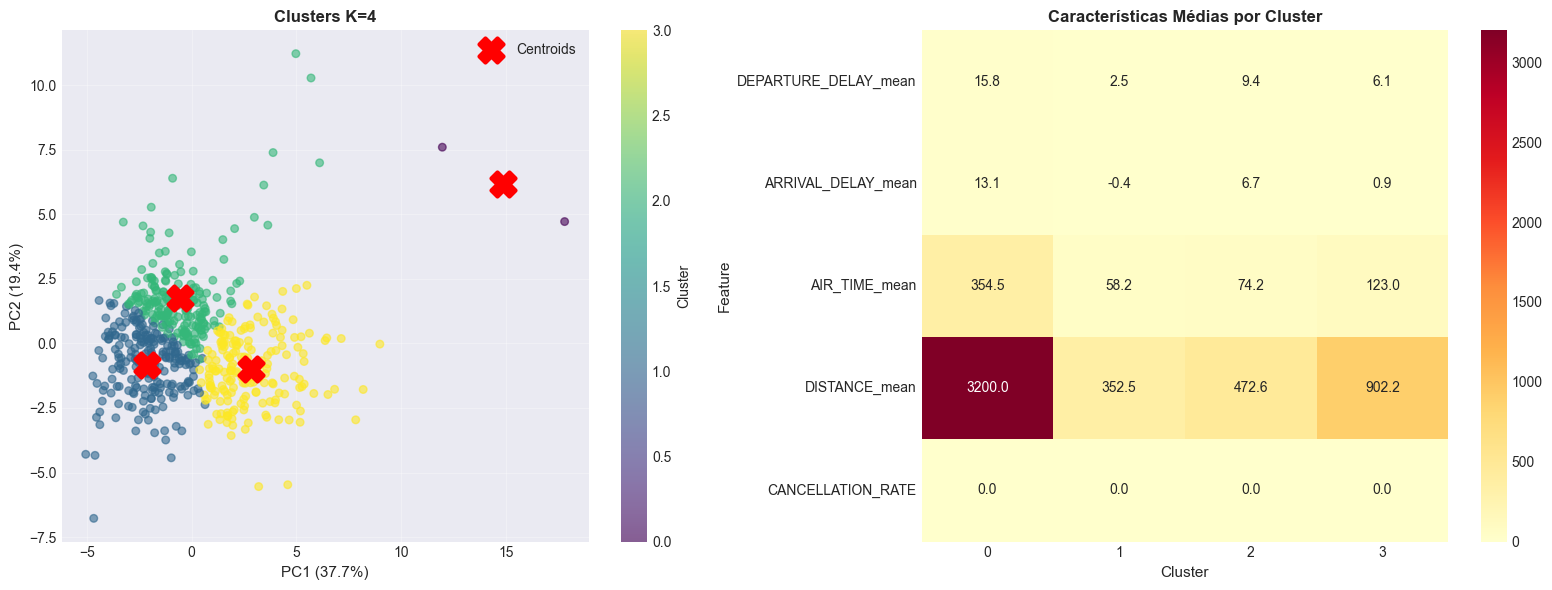

In [6]:
# Visualização dos clusters
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_cluster_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

scatter = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                         c=labels_k4, cmap='viridis', alpha=0.6, s=30)
centroids_2d = np.array([X_pca_2d[labels_k4 == i].mean(axis=0) for i in range(4)])
axes[0].scatter(centroids_2d[:, 0], centroids_2d[:, 1], 
               c='red', marker='X', s=300, linewidths=3, label='Centroids')
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[0].set_title('Clusters K=4', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label='Cluster')

features_viz = ['DEPARTURE_DELAY_mean', 'ARRIVAL_DELAY_mean', 
                'AIR_TIME_mean', 'DISTANCE_mean', 'CANCELLATION_RATE']
cluster_means = df_airports_clustered.groupby('CLUSTER')[features_viz].mean()
sns.heatmap(cluster_means.T, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1])
axes[1].set_title('Características Médias por Cluster', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=11)
axes[1].set_ylabel('Feature', fontsize=11)

plt.tight_layout()
plt.savefig('../results/clusters_k4_aeroporto.png', dpi=300, bbox_inches='tight')
plt.show()


In [7]:
# PCA com 3 componentes
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_cluster_scaled)

variance_explained = pca_3d.explained_variance_ratio_
print("Variância explicada:")
for i, var in enumerate(variance_explained, 1):
    print(f"  PC{i}: {var:.2%}")
print(f"Total: {variance_explained.sum():.2%}")

# Loadings
loadings_df = pd.DataFrame(
    pca_3d.components_.T * np.sqrt(pca_3d.explained_variance_),
    columns=['PC1', 'PC2', 'PC3'],
    index=features_clustering
)

print("\nTop 5 features por componente:")
for pc in ['PC1', 'PC2', 'PC3']:
    top = loadings_df[pc].abs().nlargest(5)
    print(f"\n{pc}:")
    for feat, val in top.items():
        print(f"  {feat}: {loadings_df.loc[feat, pc]:.4f}")


Variância explicada:
  PC1: 37.70%
  PC2: 19.40%
  PC3: 11.44%
Total: 68.53%

Top 5 features por componente:

PC1:
  ELAPSED_TIME_mean: 0.9637
  AIR_TIME_mean: 0.9629
  DISTANCE_mean: 0.9546
  ELAPSED_TIME_median: 0.8563
  AIR_TIME_median: 0.8546

PC2:
  ARRIVAL_DELAY_mean: 0.9059
  ARRIVAL_DELAY_std: 0.8448
  DEPARTURE_DELAY_mean: 0.8380
  DEPARTURE_DELAY_std: 0.8356
  ARRIVAL_DELAY_median: 0.5120

PC3:
  DISTANCE_min: 0.7518
  ARRIVAL_DELAY_median: -0.4344
  AIR_TIME_median: 0.4185
  ELAPSED_TIME_median: 0.4102
  ELAPSED_TIME_std: -0.3909


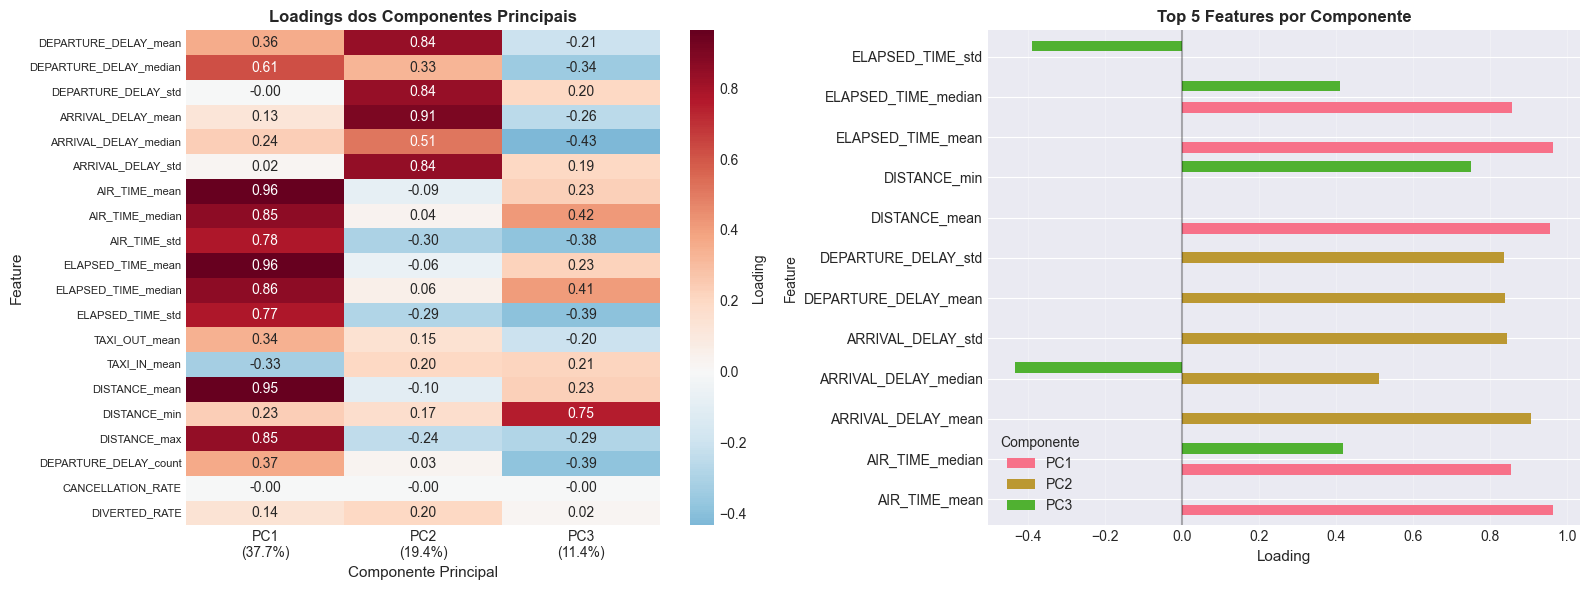

In [8]:
# Visualizações de loadings
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(loadings_df, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            ax=axes[0], cbar_kws={'label': 'Loading'},
            xticklabels=[f'PC{i+1}\n({variance_explained[i]:.1%})' for i in range(3)])
axes[0].set_title('Loadings dos Componentes Principais', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Componente Principal', fontsize=11)
axes[0].set_ylabel('Feature', fontsize=11)
axes[0].tick_params(axis='y', labelsize=8)

top_features_all = []
for pc in ['PC1', 'PC2', 'PC3']:
    top = loadings_df[pc].abs().nlargest(5)
    top_features_all.extend([(feat, loadings_df.loc[feat, pc], pc) for feat in top.index])

top_df = pd.DataFrame(top_features_all, columns=['Feature', 'Loading', 'PC'])
top_df_pivot = top_df.pivot(index='Feature', columns='PC', values='Loading').fillna(0)
top_df_pivot.plot(kind='barh', ax=axes[1], width=0.8)
axes[1].set_xlabel('Loading', fontsize=11)
axes[1].set_title('Top 5 Features por Componente', fontsize=12, fontweight='bold')
axes[1].legend(title='Componente')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].axvline(x=0, color='k', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/pca_loadings_aeroporto.png', dpi=300, bbox_inches='tight')
plt.show()


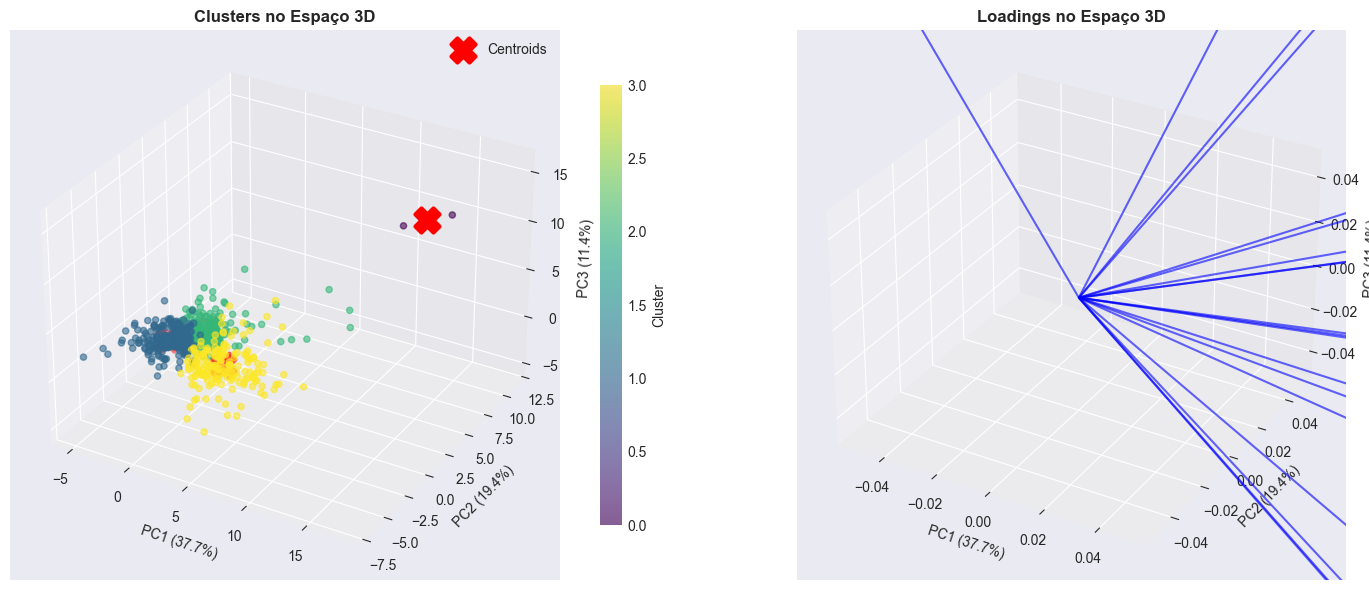

In [9]:
# Visualização 3D
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121, projection='3d')
scatter = ax1.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                     c=labels_k4, cmap='viridis', alpha=0.6, s=20)
centroids_3d = np.array([X_pca_3d[labels_k4 == i].mean(axis=0) for i in range(4)])
ax1.scatter(centroids_3d[:, 0], centroids_3d[:, 1], centroids_3d[:, 2],
           c='red', marker='X', s=300, linewidths=3, label='Centroids', zorder=10)
ax1.set_xlabel(f'PC1 ({variance_explained[0]:.1%})', fontsize=10)
ax1.set_ylabel(f'PC2 ({variance_explained[1]:.1%})', fontsize=10)
ax1.set_zlabel(f'PC3 ({variance_explained[2]:.1%})', fontsize=10)
ax1.set_title('Clusters no Espaço 3D', fontsize=12, fontweight='bold')
ax1.legend()
plt.colorbar(scatter, ax=ax1, label='Cluster', shrink=0.8)

ax2 = fig.add_subplot(122, projection='3d')
origin = np.zeros((len(loadings_df), 3))
ax2.quiver(origin[:, 0], origin[:, 1], origin[:, 2],
          loadings_df['PC1'].values, loadings_df['PC2'].values, loadings_df['PC3'].values,
          color='blue', alpha=0.6, arrow_length_ratio=0.1)
for pc in ['PC1', 'PC2', 'PC3']:
    top_feat = loadings_df[pc].abs().nlargest(1).index[0]
    x, y, z = loadings_df.loc[top_feat, 'PC1'], loadings_df.loc[top_feat, 'PC2'], loadings_df.loc[top_feat, 'PC3']
    ax2.text(x, y, z, top_feat.replace('_', ' ')[:15], fontsize=8)
ax2.set_xlabel(f'PC1 ({variance_explained[0]:.1%})', fontsize=10)
ax2.set_ylabel(f'PC2 ({variance_explained[1]:.1%})', fontsize=10)
ax2.set_zlabel(f'PC3 ({variance_explained[2]:.1%})', fontsize=10)
ax2.set_title('Loadings no Espaço 3D', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/pca_3d_aeroporto.png', dpi=300, bbox_inches='tight')
plt.show()
